In [253]:
%matplotlib inline

# numbers
import numpy as np
import pandas as pd

# stats
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# plots
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os, re
from pprint import pprint


In [254]:
# learn you some machines
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from keras.optimizers import adam
from keras.utils.np_utils import to_categorical

In [255]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    
    ## Automatic:
    #X_cov = np.cov(X_std.T)
    
    # Manual:
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov

In [256]:
testing_df = pd.read_csv('data/optdigits/optdigits.tes',header=None)
X_testing,  y_testing  = testing_df.loc[:,0:63],  testing_df.loc[:,64]

training_df = pd.read_csv('data/optdigits/optdigits.tra',header=None)
X_training, y_training = training_df.loc[:,0:63], training_df.loc[:,64]

X_train, _, _ = get_normed_mean_cov(X_training)
X_test, _, _ = get_normed_mean_cov(X_testing)

y_train = y_training
y_test = y_testing

X_train = X_train.reshape(-1,8,8)
X_test = X_test.reshape(-1,8,8)

In [257]:
def show(img,ax=None):
    if(ax):
        ax.imshow(img, cmap="gray", interpolation="none")
    else:
        imshow(img, cmap="gray", interpolation="none")

Digit: 6


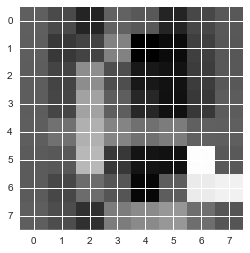

In [258]:
ix = 58
img = X_train[ix]
print "Digit: %d"%(y_train[ix])
show(img)

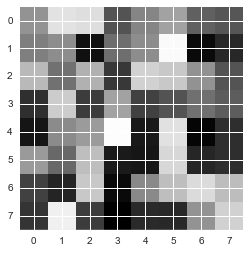

In [259]:
randimg = np.random.uniform(0, 1, (8, 8))
show(randimg)

In [260]:
randdir = np.random.rand(8,8)

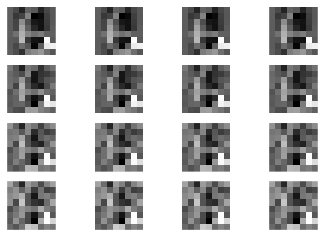

In [261]:
for i in range(16):
    subplot(4,4,i+1)
    show(img+i/4*randdir)
    plt.xticks([])
    plt.yticks([])

In [384]:
X_flat = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_testflat = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

y_flat = y_training
y_testflat = y_testing

In [385]:
knn = NearestNeighbors(len(X_flat))
knn.fit(X_flat)

# C = 100
knn1C = NearestNeighbors(100)
knn1C.fit(X_flat)

# D = 500
knn1D = NearestNeighbors(500)
knn1D.fit(X_flat)

# M = 1,000
knn1M = NearestNeighbors(1000)
knn1M.fit(X_flat)

# 3M = 3,000
knn3M = NearestNeighbors(3000)
knn3M.fit(X_flat)


print ""

In [386]:
print img.shape

(8, 8)


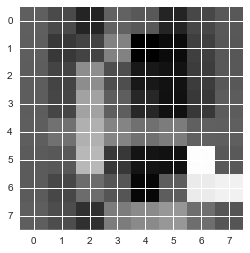

In [387]:
show(img)

In [432]:
def get_dist_neighbors(myknn):
    distances, neighbors = myknn.kneighbors(img.flatten().reshape(1, -1))
    neighbors = neighbors[0]
    distances = distances[0]
    return neighbors, distances

neighbors,   distances   = get_dist_neighbors(knn)
neighbors1C, distances1C = get_dist_neighbors(knn1C)
neighbors1D, distances1D = get_dist_neighbors(knn1D)
neighbors1M, distances1M = get_dist_neighbors(knn1M)
neighbors3M, distances3M = get_dist_neighbors(knn3M)

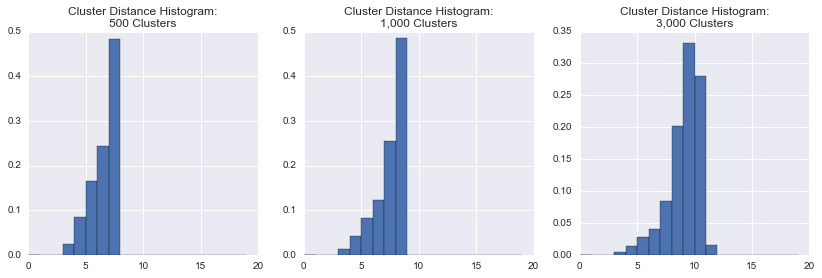

In [433]:
fig = plt.figure(figsize=(14,4))

axes = (fig.add_subplot(131+j) for j in range(3))

for ax,dist,plt_title in zip(
                   axes,
                   [distances1D,distances1M,distances3M],
                   ["500 Clusters","1,000 Clusters","3,000 Clusters"]):
    ax.hist(dist[1:], bins=range(20), normed=True)
    ax.set_title("Cluster Distance Histogram:\n%s"%(plt_title))

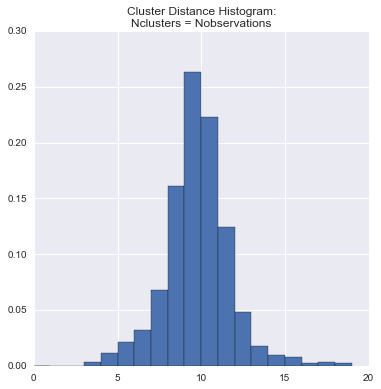

In [434]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.hist(distances[1:], bins=range(20), normed=True)
ax1.set_title('Cluster Distance Histogram:\nNclusters = Nobservations')

plt.show()

In [435]:
print neighbors[1]

271


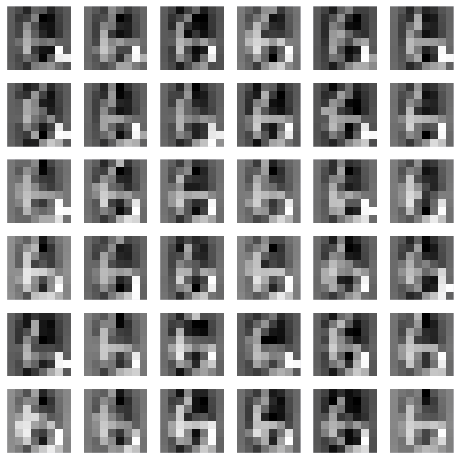

In [436]:
fig = plt.figure(figsize=(8,8))
for j, train_ix in enumerate(neighbors[:36]):
    plt.subplot(6,6,j+1)
    grid_data = X_train[train_ix]  # reshape from 1d to 2d pixel array
    show(grid_data)
    plt.xticks([])
    plt.yticks([])

In [437]:
print X_flat.shape
print y_flat.shape

(3823, 64)
(3823,)


In [444]:
input_img = Input(shape=(64,))
encoded = Dense(32, activation='relu')(input_img)

encoded = Dense(2)(encoded) #keep it linear here.

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation = 'sigmoid')(decoded)

autoencoder = Model(input=input_img, output=decoded)

In [445]:
#autoencoder.compile(optimizer = "adam", loss = "mse")
autoencoder.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [446]:
# NOTE: 
# We are fitting X_flat to X_flat,
# b/c we are using the neural network for 
# dimensional reduction.
# The observables don't come into play here.

num_epochs = 10
hist = autoencoder.fit(X_flat, X_flat, batch_size = 128,
                       nb_epoch = num_epochs, verbose = 3)
#                       validation_data=(X_testflat,X_testflat))

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [447]:
print X_testflat.shape
#scores = autoencoder.evaluate(X_testflat, y_test, verbose=0)

(1797, 64)


In [448]:
encoder = Model(input = input_img, output = encoded)

#building the decoder:
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-2]
encoded_layer_2 = autoencoder.layers[-1]

decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = Model(input=encoded_input, output=decoder)

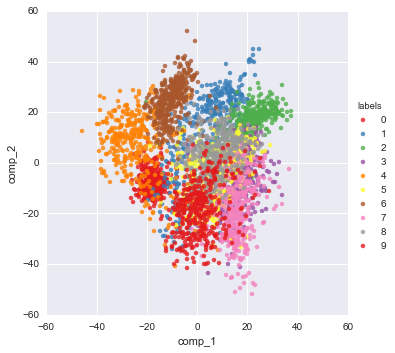

In [466]:
X_proj = encoder.predict(X_flat)

proj = pd.DataFrame(X_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train
sns.lmplot("comp_1", "comp_2", hue = "labels", 
           data = proj, 
           hue_order=range(10), fit_reg=False, 
           palette="Set1")
plt.show()

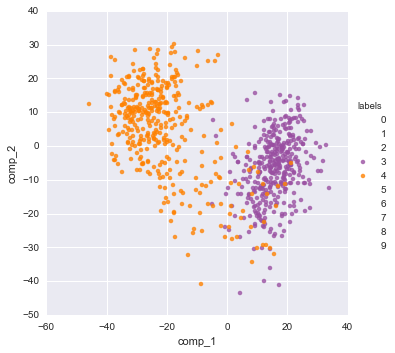

In [488]:
X_proj = encoder.predict(X_flat)

d1 = 4
d2 = 3

proj = pd.DataFrame(X_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train

projplot = proj[ proj['labels'].apply(lambda x : (x==d1 or x==d2)) ]

sns.lmplot("comp_1", "comp_2", hue = "labels", 
           data = projplot,
           hue_order=range(10), fit_reg=False, 
           palette="Set1")
plt.show()

In [450]:
def show_digit(ix):
    
    print "Digit classification: %d"%(y_train[ix])
    
    fig = plt.figure(figsize=(5,5))
    ax1, ax2 = [fig.add_subplot(221+i) for i in range(2)]
    orig = X_train[ix]
    back_proj = autoencoder.predict( np.expand_dims(X_train[ix].flatten(), 0) ).reshape(8,8)    
    show(orig,ax=ax1)
    show(back_proj,ax=ax2)
    
    ax1.set_title('Original')
    ax2.set_title('Back-Projected')

Digit classification: 2


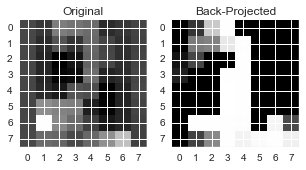

In [458]:
show_digit(1006)

Digit classification: 7


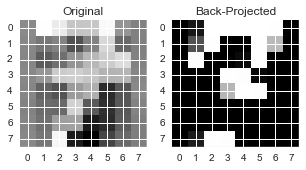

In [459]:
show_digit(999)

Digit classification: 3


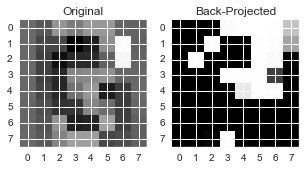

In [460]:
show_digit(1009)

In [530]:
input_img = Input(shape=(64,))

encoded = Dense(32, activation='relu')(input_img)
encoded = Dense(2)(encoded) #keep it linear here.
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation = 'sigmoid')(decoded)

autoencoder = Model(input=input_img, output=decoded)

#autoencoder.compile(optimizer = "adam", loss = "mse")
autoencoder.compile(optimizer = "adam", loss = "categorical_crossentropy")

num_epochs = 25
hist = autoencoder.fit(X_flat, X_flat, batch_size = 128,
                       nb_epoch = num_epochs, verbose = 3)


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25


In [548]:
# Make a forward-projection model (many-to-few): encoder

encoder = Model(input = input_img, output = encoded)


# Make a back-projection model (few-to-many): decoder
encoded_input = Input(shape=(2,))

encoded_layer_1 = autoencoder.layers[-2]
encoded_layer_2 = autoencoder.layers[-1]

In [549]:
decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = Model(input=encoded_input, output=decoder)

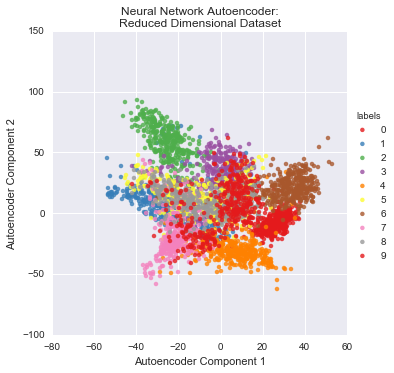

In [600]:

#print X_flat.shape
#print X_proj.shape

X_proj = encoder.predict(X_flat)

proj = pd.DataFrame(X_proj)
proj.columns = ["comp_1", "comp_2"]#, "comp_3", "comp_4"]
proj["labels"] = y_train

sns.lmplot("comp_1", "comp_2", hue = "labels", 
           data = proj, 
           hue_order=range(10), fit_reg=False,
           palette="Set1", legend=True, legend_out=True)

plt.title('Neural Network Autoencoder:\nReduced Dimensional Dataset')
plt.xlabel("Autoencoder Component 1")
plt.ylabel("Autoencoder Component 2")
plt.show()

Digit category: 7


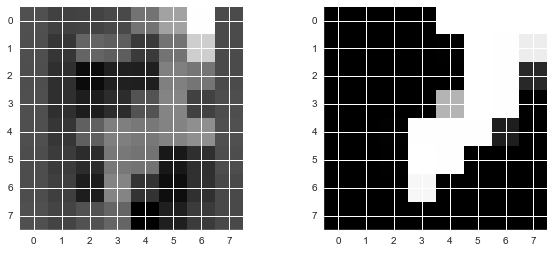

In [559]:
def plot_backprojection(ix):
    backprojection = autoencoder.predict(np.expand_dims(X_train[ix].flatten(), 0)).reshape(8,8)
    original = X_train[ix]
    response = y_train[ix]
    
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = [fig.add_subplot(121+i) for i in range(2)]

    print "Digit category: %d"%(response)
    show(original,ax=ax1)
    show(backprojection,ax=ax2)

plot_backprojection(20)

Digit category: 2


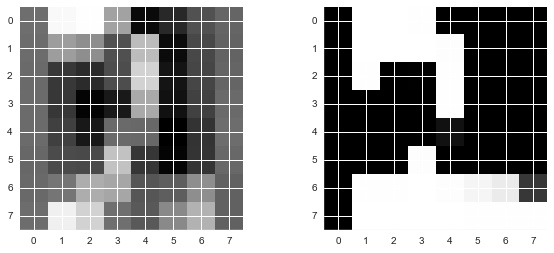

In [560]:
plot_backprojection(140)

Digit category: 3


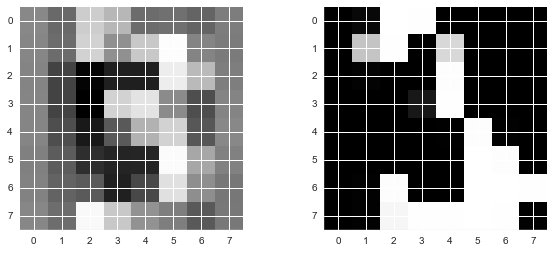

In [561]:
plot_backprojection(3000)

In [569]:
from __future__ import division

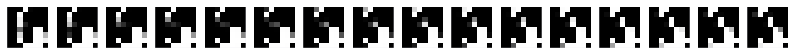

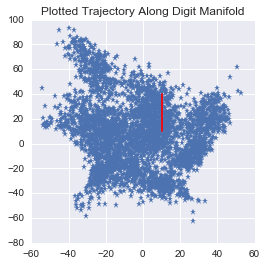

In [605]:
# Vector-digits plot 
pts = []
fig = plt.figure(figsize=(14,1))
for i in range(16):
    pt = np.array([[10, 10+2*i]])
    plt.subplot(1,16,i+1)    
    show(decoder.predict(pt).reshape((8, 8)))
    plt.xticks([])
    plt.yticks([])
    
    pts.append(pt)

pts = np.array(pts).squeeze()

fig = plt.figure(figsize=(4,4))

plt.plot(proj['comp_1'],proj['comp_2'],'*')
plt.plot(pts[:,0],pts[:,1],'r-')
plt.title('Plotted Trajectory Along Digit Manifold')

# Plot data points on scatterplot with pts line
plt.show()

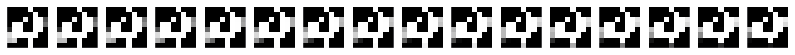

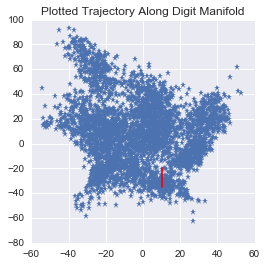

In [631]:
# Vector-digits plot 
pts = []
fig = plt.figure(figsize=(14,1))
for i in range(16):
    pt = np.array([[10, -20-i]])
    plt.subplot(1,16,i+1)    
    show(decoder.predict(pt).reshape((8, 8)))
    plt.xticks([])
    plt.yticks([])
    
    pts.append(pt)

pts = np.array(pts).squeeze()

fig = plt.figure(figsize=(4,4))

plt.plot(proj['comp_1'],proj['comp_2'],'*')
plt.plot(pts[:,0],pts[:,1],'r-')
plt.title('Plotted Trajectory Along Digit Manifold')

# Plot data points on scatterplot with pts line
plt.show()

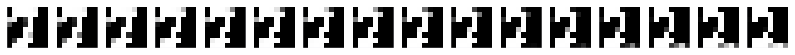

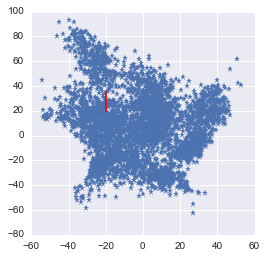

In [607]:
# Vector-digits plot 
pts = []
fig = plt.figure(figsize=(14,1))
for i in range(16):
    pt = np.array([[-20, 20 + i]])
    plt.subplot(1,16,i+1)    
    show(decoder.predict(pt).reshape((8, 8)))
    plt.xticks([])
    plt.yticks([])
    
    pts.append(pt)

pts = np.array(pts).squeeze()

fig = plt.figure(figsize=(4,4))

plt.plot(proj['comp_1'],proj['comp_2'],'*')
plt.plot(pts[:,0],pts[:,1],'r-')

# Plot data points on scatterplot with pts line
plt.show()

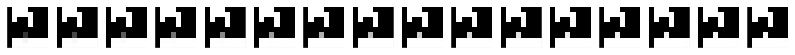

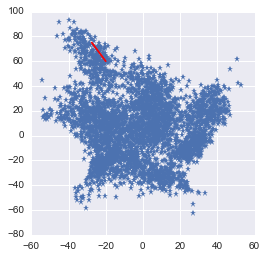

In [609]:
# Vector-digits plot 
pts = []
fig = plt.figure(figsize=(14,1))
for i in range(16):
    pt = np.array([[ -20-(i/2), 60 + (i)]])
    plt.subplot(1,16,i+1)    
    show(decoder.predict(pt).reshape((8, 8)))
    plt.xticks([])
    plt.yticks([])
    
    pts.append(pt)

pts = np.array(pts).squeeze()

fig = plt.figure(figsize=(4,4))

plt.plot(proj['comp_1'],proj['comp_2'],'*')
plt.plot(pts[:,0],pts[:,1],'r-')

# Plot data points on scatterplot with pts line
plt.show()

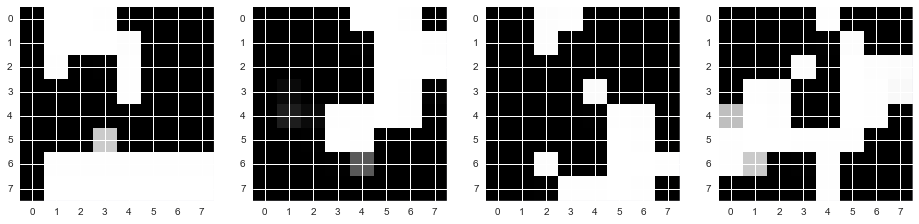

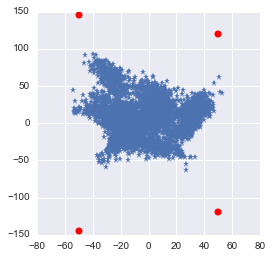

In [634]:
# ---------------
# Pick some points way off the manifold
# and visualize their back-projection

#fig = plt.figure(figsize=(6,6))
#axes = [fig.add_subplot(221+i) for i in range(4)]

fig = plt.figure(figsize=(16,4))
axes = [fig.add_subplot(141+i) for i in range(4)]

pts = [[-50,145],
       [-50,-145],
       [ 50,120],
       [ 50,-120]]

for pt,ax in zip(pts,axes):
    xcoord = pt[0]
    ycoord = pt[1]
    pt = np.array([[xcoord, ycoord]])
    show(decoder.predict(pt).reshape((8, 8)), ax=ax)

    
# ---------
# Plot the outlier points on the manifold,
# with big ugly clown noses,
# along with the rest of the observations

pts = np.array(pts).squeeze()

fig = plt.figure(figsize=(4,4))

plt.plot(proj['comp_1'],proj['comp_2'],'*')
plt.plot(pts[:,0],pts[:,1],'ro')
plt.ylim([-150,150])
plt.xlim([-80,80])

# Plot data points on scatterplot with pts line
plt.show()

In [ ]:
# Here, we apply back-projection to the test data.

X_testproj = encoder.predict(X_testflat)
X_testhat = decoder.predict(X_testproj)

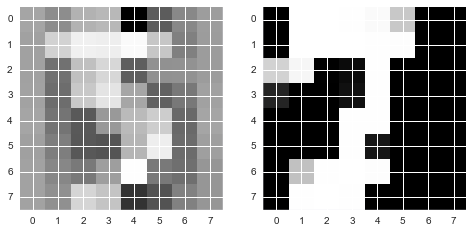

In [653]:
# Plot of results
fig = plt.figure(figsize=(8,4))
axes = [fig.add_subplot(121+i) for i in range(2)]

ix = 120

data = [X_testflat[ix], X_testhat[ix]]
for ax,dat in zip(axes,data):
    show(dat.reshape((8,8)), ax=ax)


In [655]:
# Measure of how well it does

mse = ((X_testhat - X_testflat)**2).mean(axis=None)
print mse

0.891074248852
